## Contralateral Bruxism/MEMA analysis

This notebook will 
- Process and generate reports for all the dataset (if needed)
- Display within-subject with contralateral recording of EMG/MEMA results
- Display group analysis differences between effect variables (masking, VAS, etc.) and contralateral differences

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file_bruxism = "data/reports_and_datas_bruxism.pk"
results_file_mema = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change to --overwrite True if you want to force to recompute the results
%run ../compute_results.py --bruxism True --overwrite False --mema True


config loaded.
Performs Bruxism: <True>
Performs MEMA: <True>
Will overwrite existing results: <False>
parameters set
result files exist: Reports creation skipped.


# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file_mema).to_dict()
results_bruxism = pd.read_pickle(results_file_bruxism).to_dict()

THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])
THR_classif_bruxism = np.array(results_bruxism[list(results_bruxism.keys())[0]]["THR_classif"])


data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & emg ==1')
resmed_files = data_info.query('filename.str.contains("resmed")')
sync_files = np.concatenate([resmed_files["filename"].values, resmed_files["filename"].str.replace('_resmed', '', regex=True).values])
data_info = data_info.query('filename.isin(@sync_files)')
print(f"Valid files for sync {data_info.shape[0]}")
data_info.loc[data_info["filename"].isin(resmed_files["filename"]), "condition"] = 'resmed'
print(data_info[["filename", "condition", "mema", "emg","Laterality" ]])

# keep only results from query
results= {filename:results[filename] for filename in data_info["filename"].values}
results_bruxism= {filename:results_bruxism[filename] for filename in data_info["filename"].values}

Valid files for sync 12
                   filename    condition  mema  emg  Laterality
28         1HB20_nuit_1.edf  habituation     1    1         1.0
29         1HB20_nuit_2.edf  habituation     1    1         1.0
36         1SL21_nuit_2.edf  habituation     1    1         1.0
37         1SL21_nuit_3.edf  habituation     1    1         1.0
39         1UC22_nuit_2.edf  habituation     1    1         0.5
40         1UC22_nuit_1.edf  habituation     1    1         0.5
51  1HB20_nuit_1_resmed.edf       resmed     1    1         1.0
52  1HB20_nuit_2_resmed.edf       resmed     1    1         1.0
53  1SL21_nuit_2_resmed.edf       resmed     1    1         1.0
54  1SL21_nuit_3_resmed.edf       resmed     1    1         1.0
55  1UC22_nuit_1_resmed.edf       resmed     1    1         0.5
56  1UC22_nuit_2_resmed.edf       resmed     1    1         0.5


## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

In [5]:
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('MEMA scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

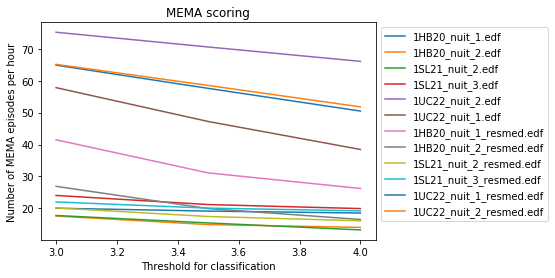

In [6]:
plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
plot_inter_subjects(results, value)

## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

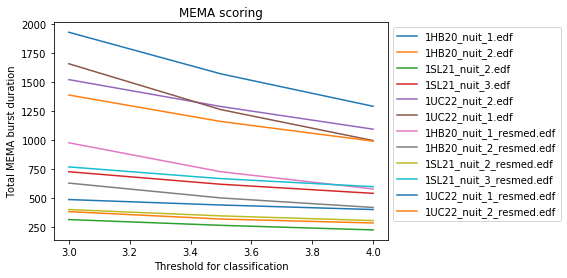

In [7]:
plt.figure()
value = "Total MEMA burst duration"
plot_inter_subjects(results, value)

## Logs of the preprocessing : 

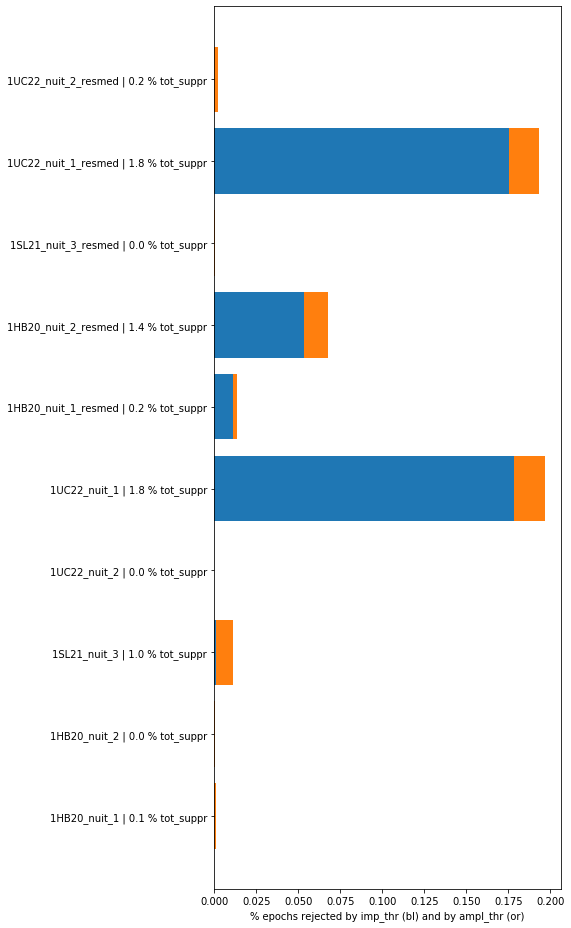

In [8]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results_bruxism.keys():
    if results_bruxism[elm]["log"]["bruxism"]['suppressed_overall']/results_bruxism[elm]["log"]["bruxism"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results_bruxism[elm]["log"]["bruxism"]['suppressed_overall']/results_bruxism[elm]["log"]["bruxism"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results_bruxism[elm]["log"]["IMP"]['suppressed_overall']/results_bruxism[elm]["log"]["IMP"]['total_nb_epochs']))
        suppr_amp.append(results_bruxism[elm]["log"]["bruxism"]['suppressed_overall']/results_bruxism[elm]["log"]["bruxism"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Comparing episode frequency with variability tinnitus

In [9]:
# format reports
reports = None
for filename in results_bruxism.keys():
    print(filename)
    report = pd.DataFrame(results[filename]["reports"]) 
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename

    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["VAS_I_delta"].apply(map_category)

reports = reports.merge(data_info, on="filename")

1HB20_nuit_1.edf
1HB20_nuit_2.edf
1SL21_nuit_2.edf
1SL21_nuit_3.edf
1UC22_nuit_2.edf
1UC22_nuit_1.edf
1HB20_nuit_1_resmed.edf
1HB20_nuit_2_resmed.edf
1SL21_nuit_2_resmed.edf
1SL21_nuit_3_resmed.edf
1UC22_nuit_1_resmed.edf
1UC22_nuit_2_resmed.edf


In [10]:
#Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus stable : 2, ['1HB20', '1HB20']
Tinnitus decrease : 4, ['1HB20', '1SL21', '1HB20', '1SL21']
Tinnitus increase : 6, ['1SL21', '1UC22', '1UC22', '1SL21', '1UC22', '1UC22']


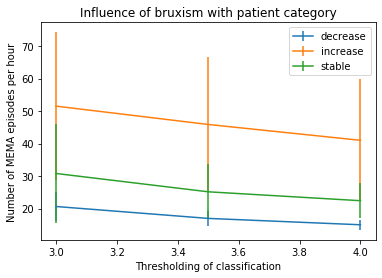

In [11]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of bruxism with patient category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

## Displaying correlation between quantitative measurements and Tinnitus

In [12]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-1] #(remove power ratio)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


<ipython-input-13-eecfa1d0f872>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
<ipython-input-13-eecfa1d0f872>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
<ipython-input-13-eecfa1d0f872>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

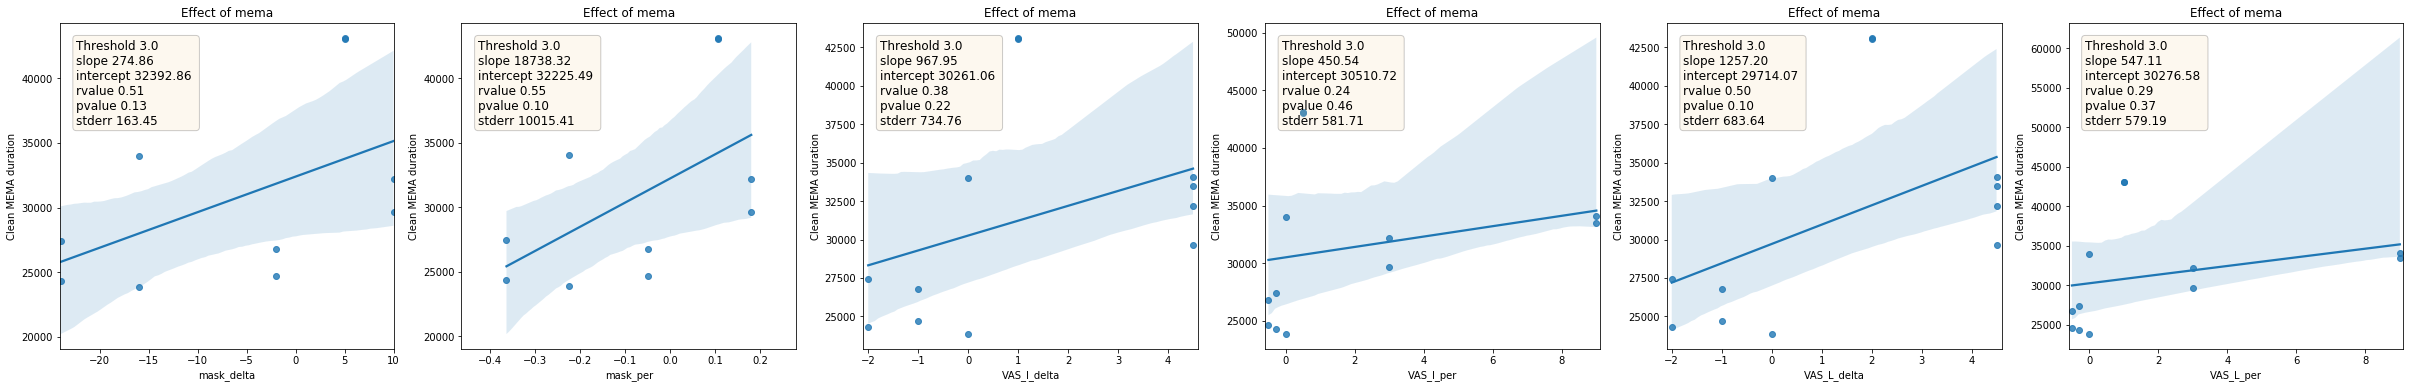

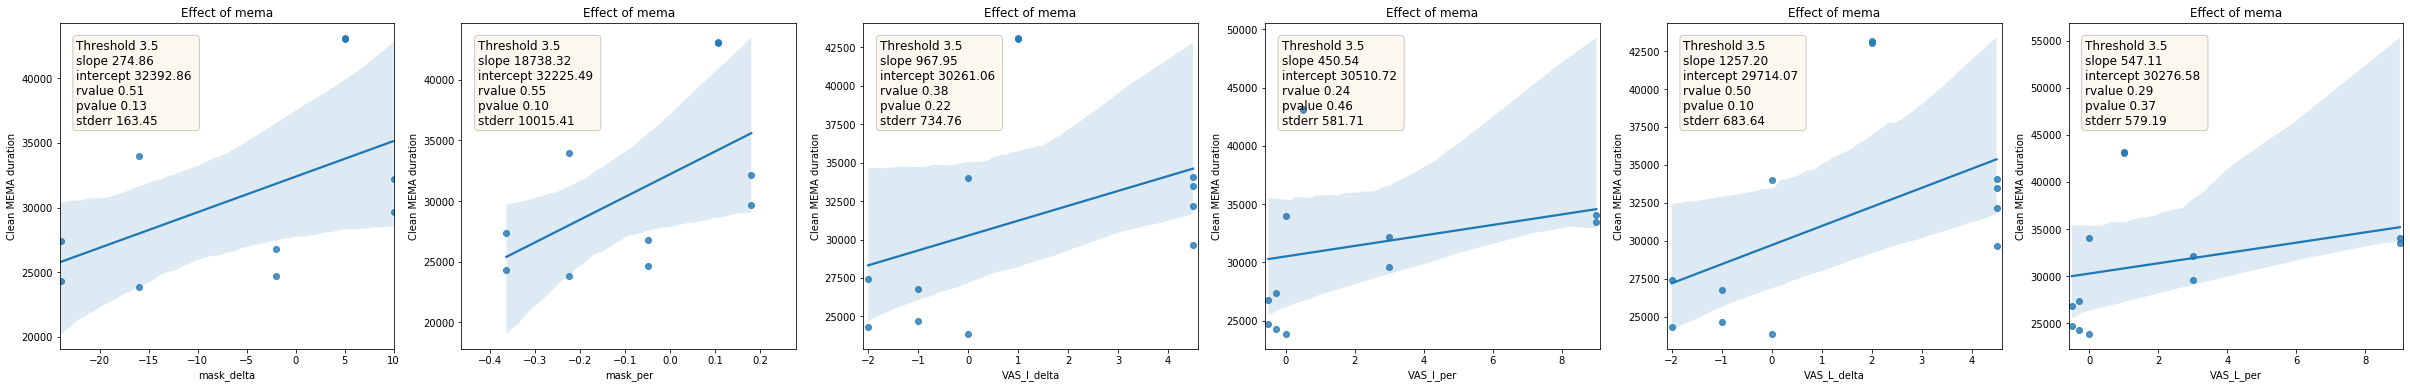

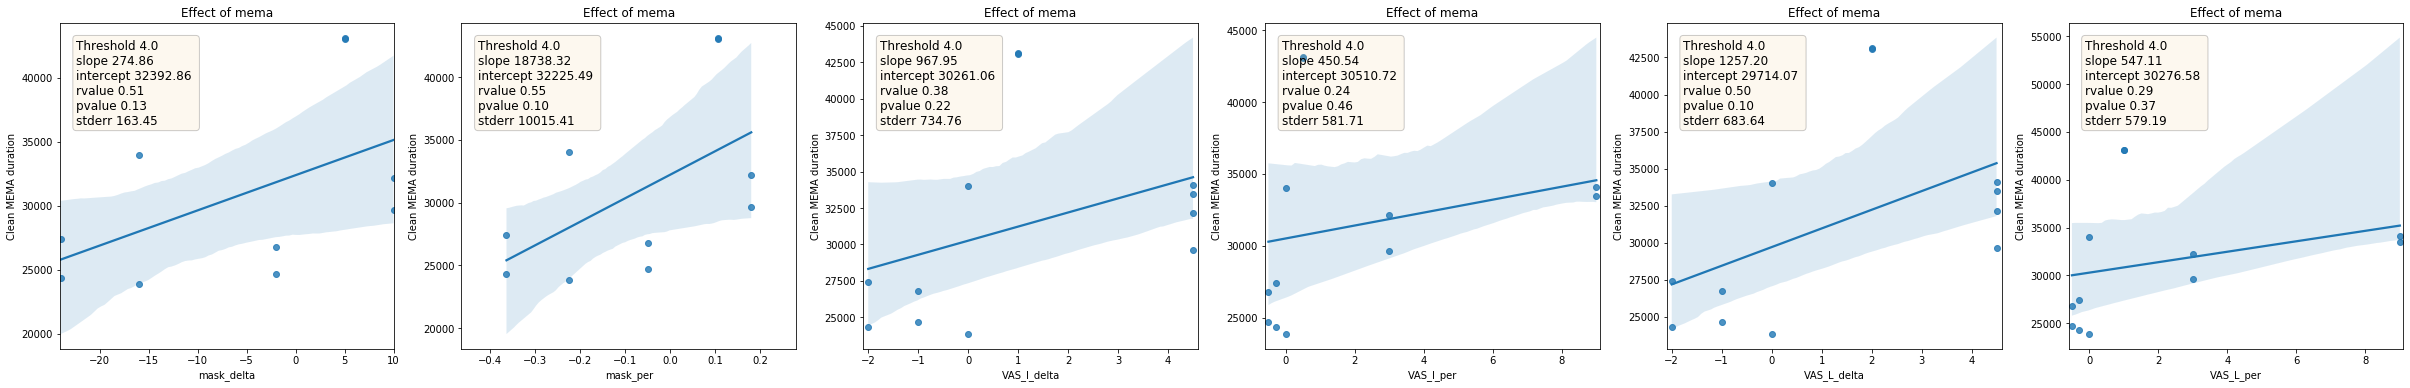

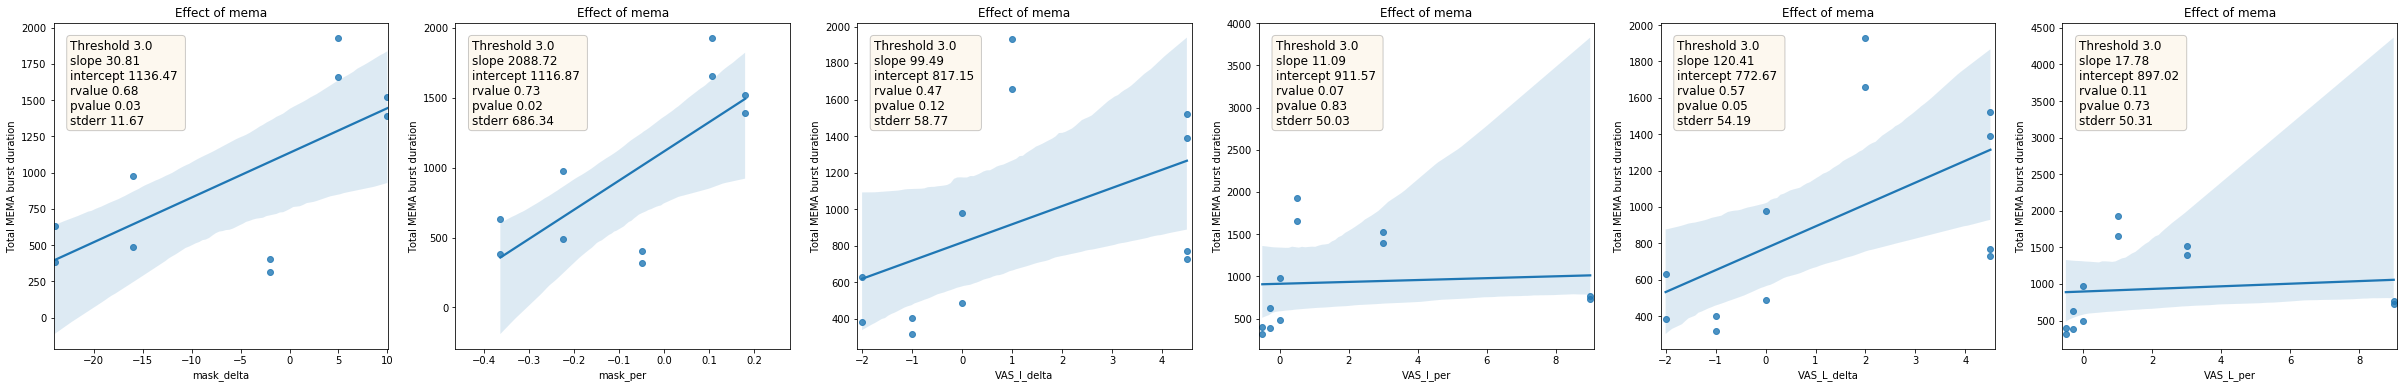

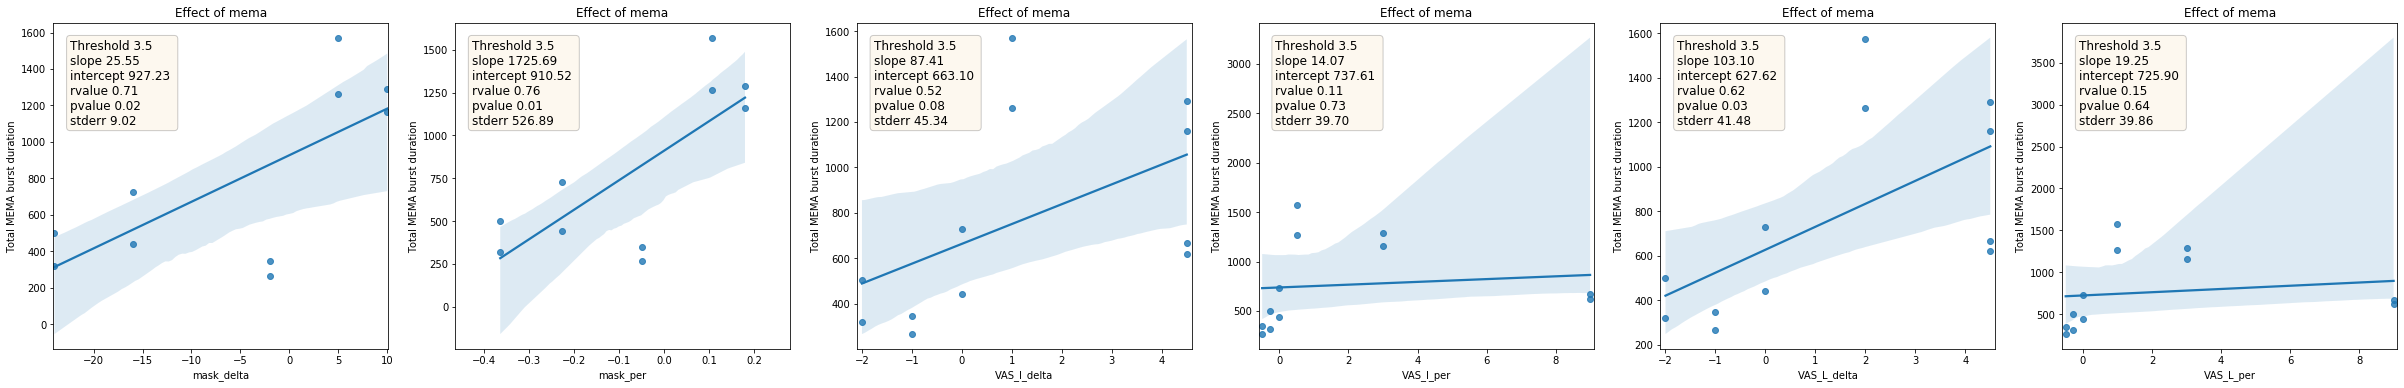

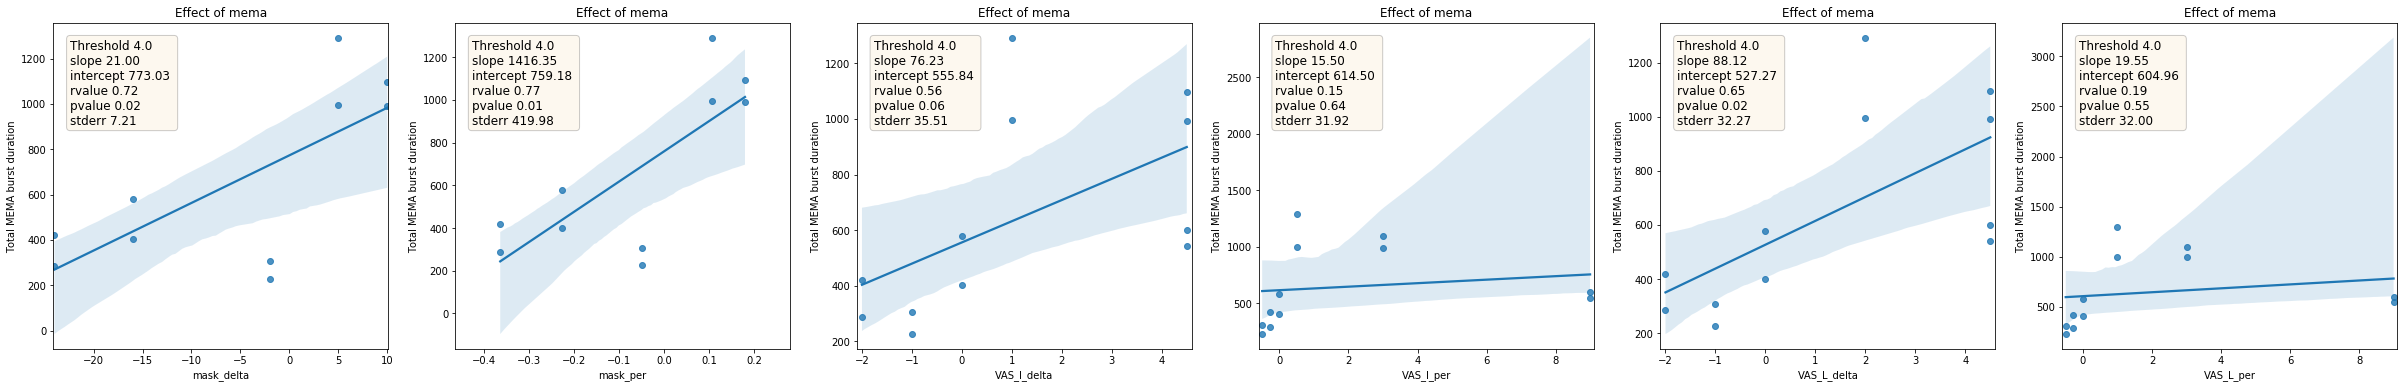

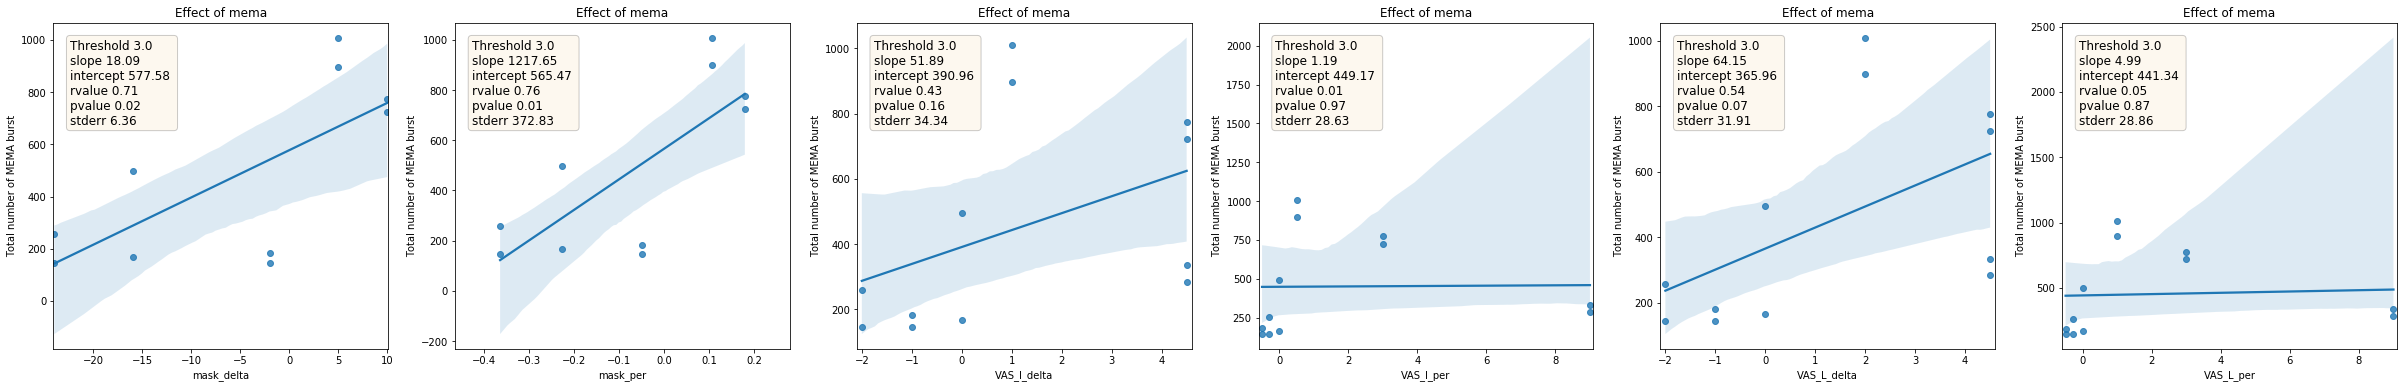

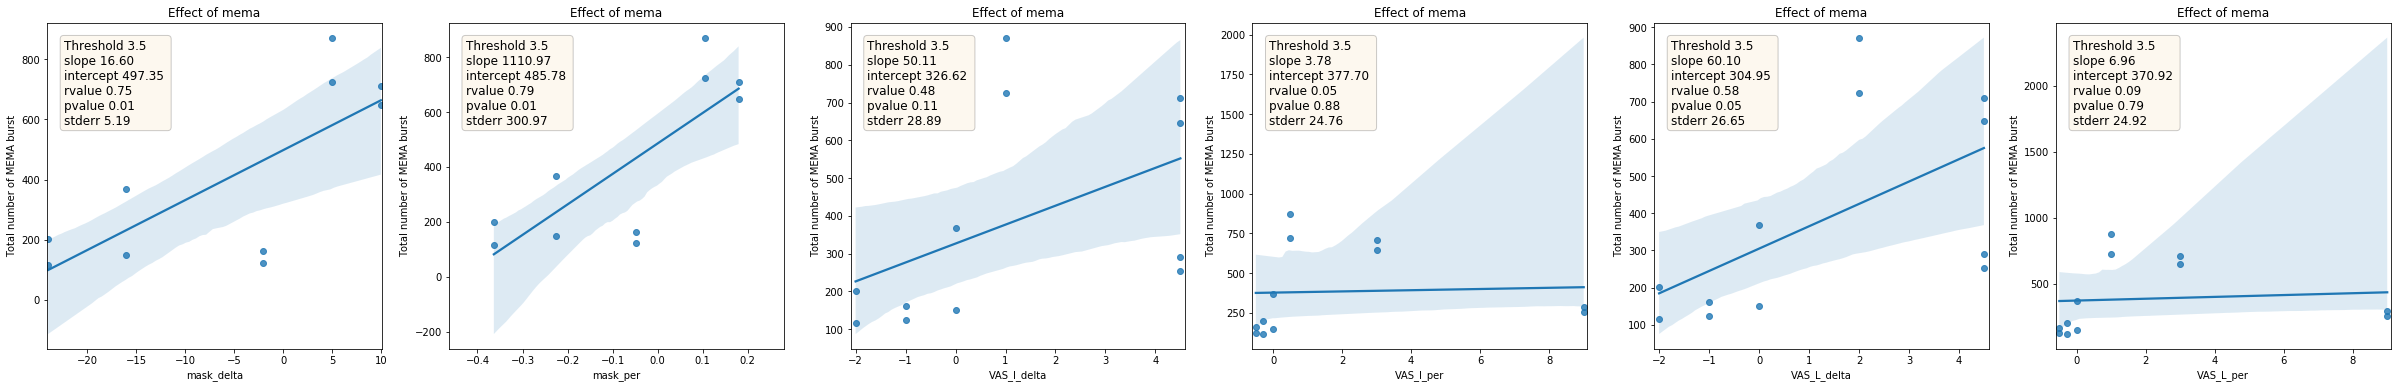

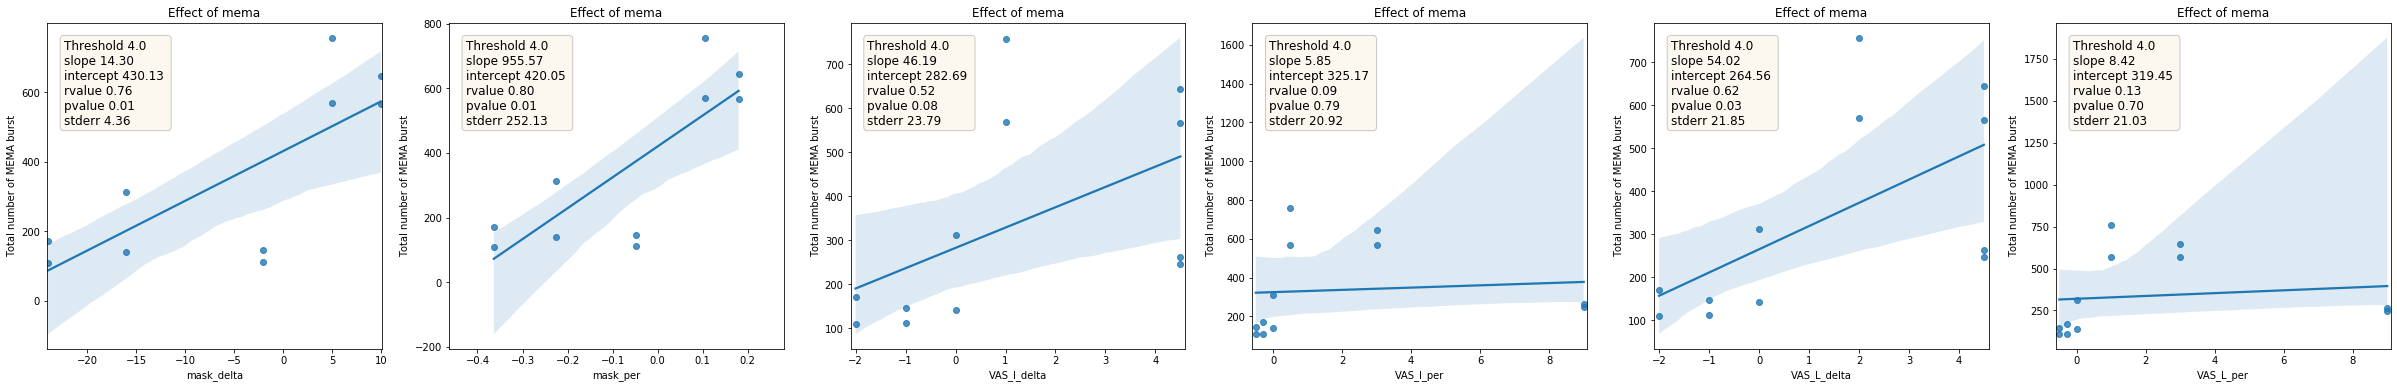

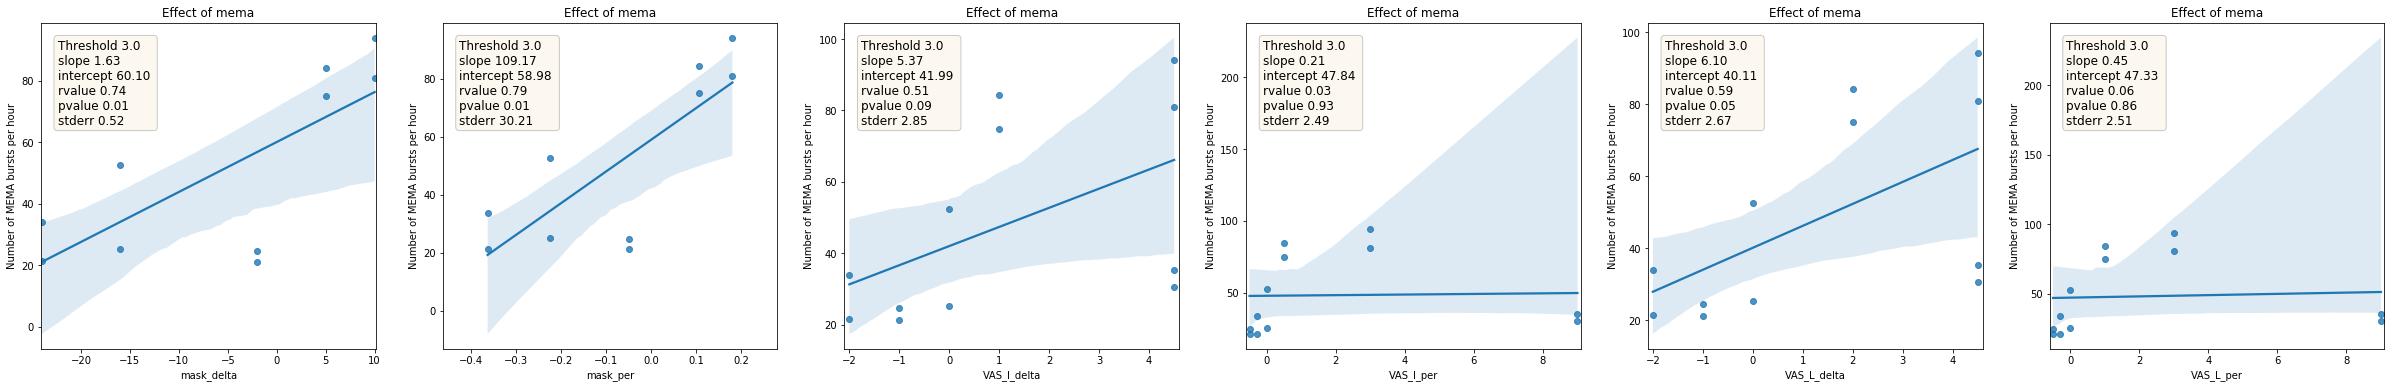

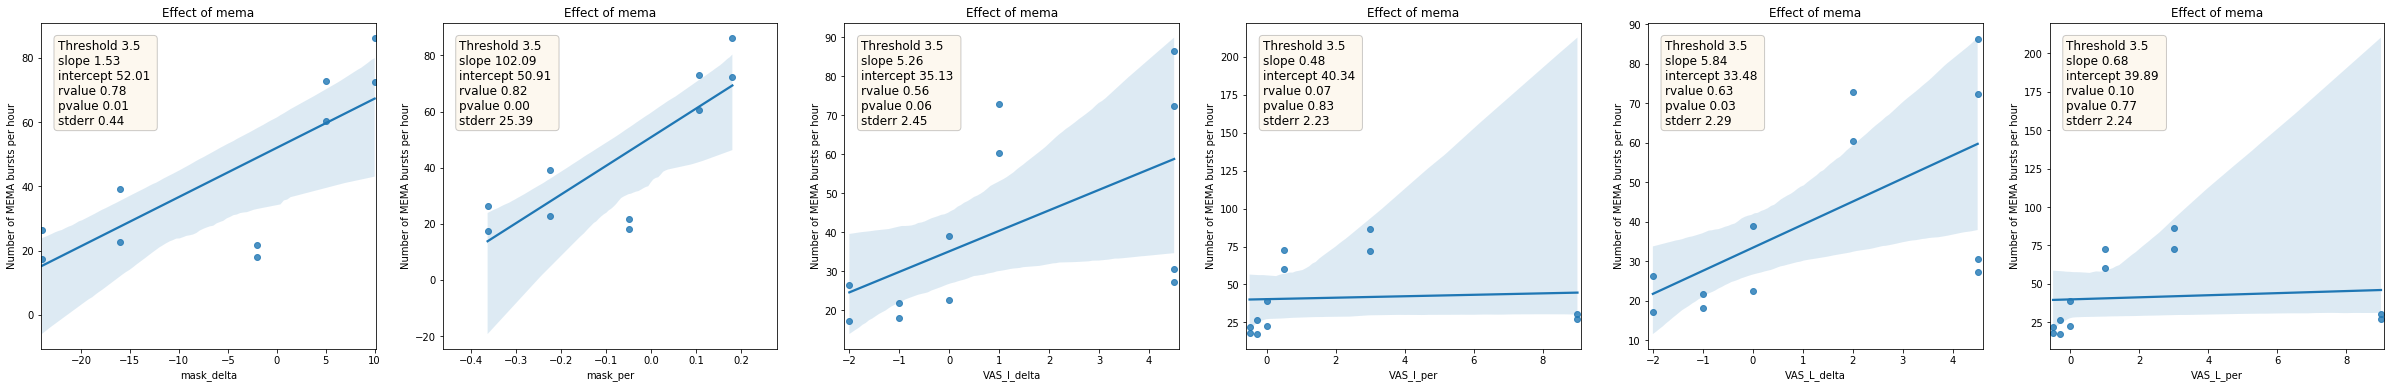

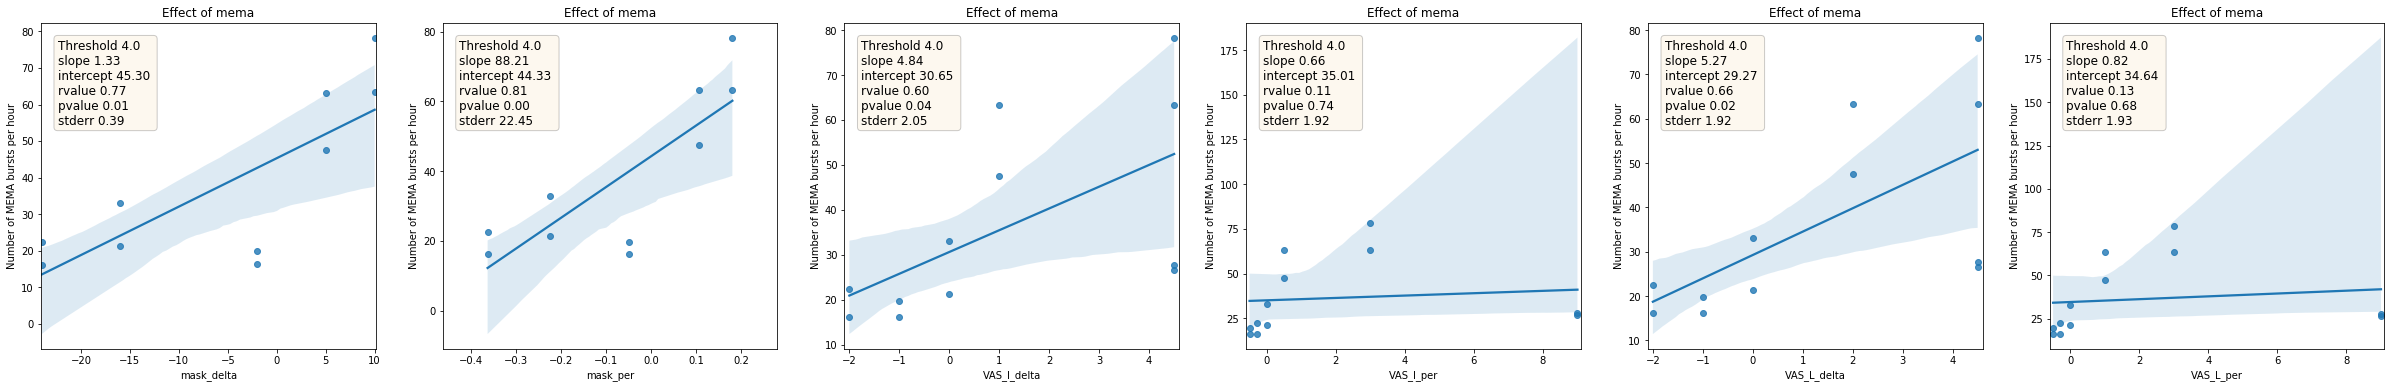

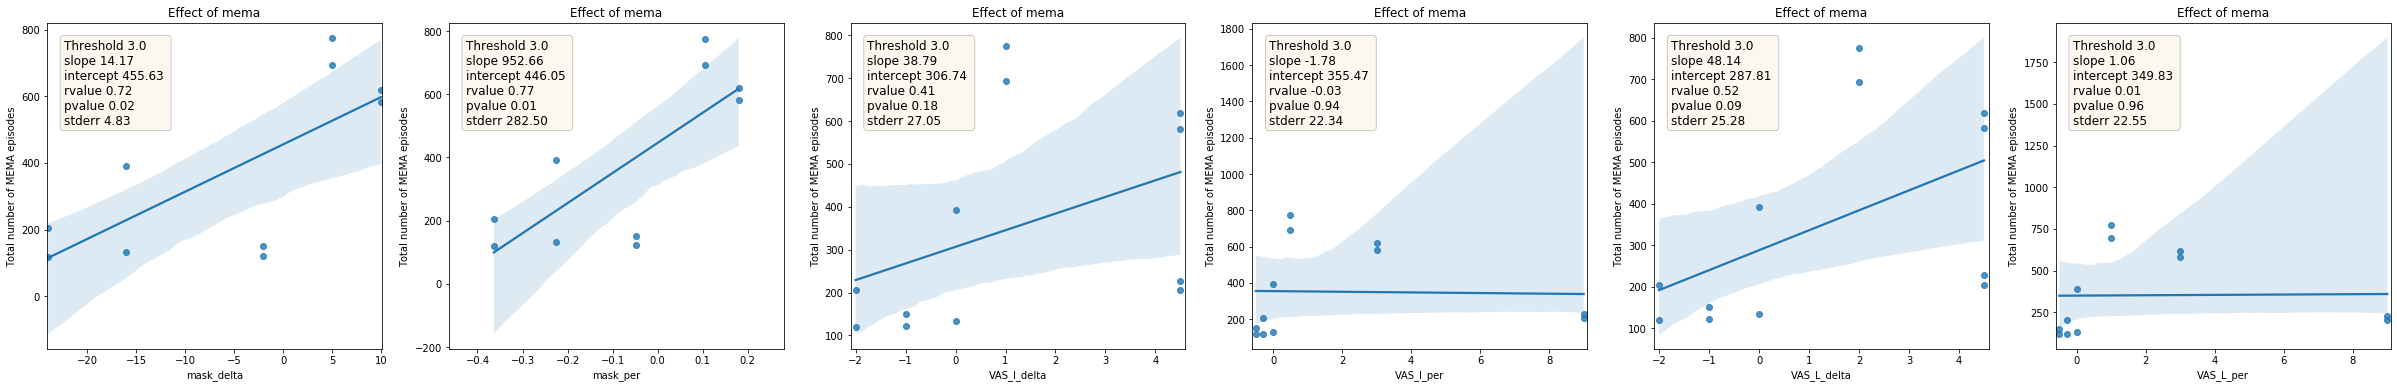

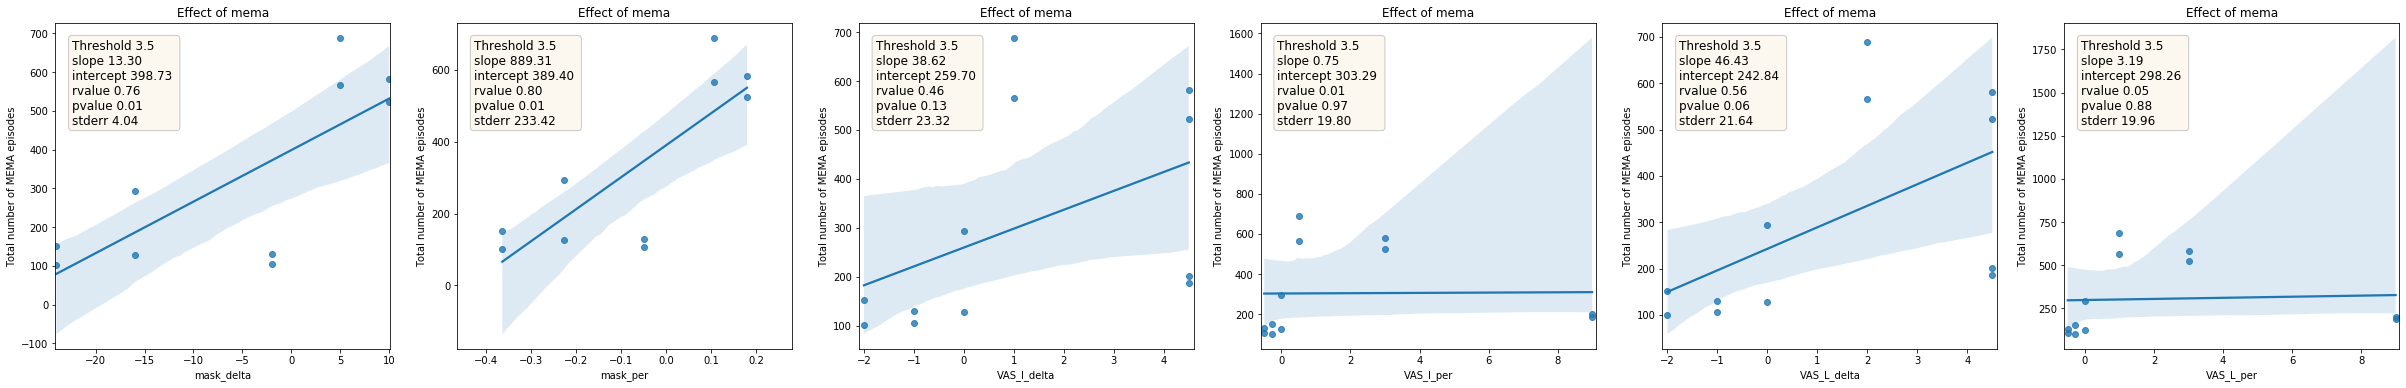

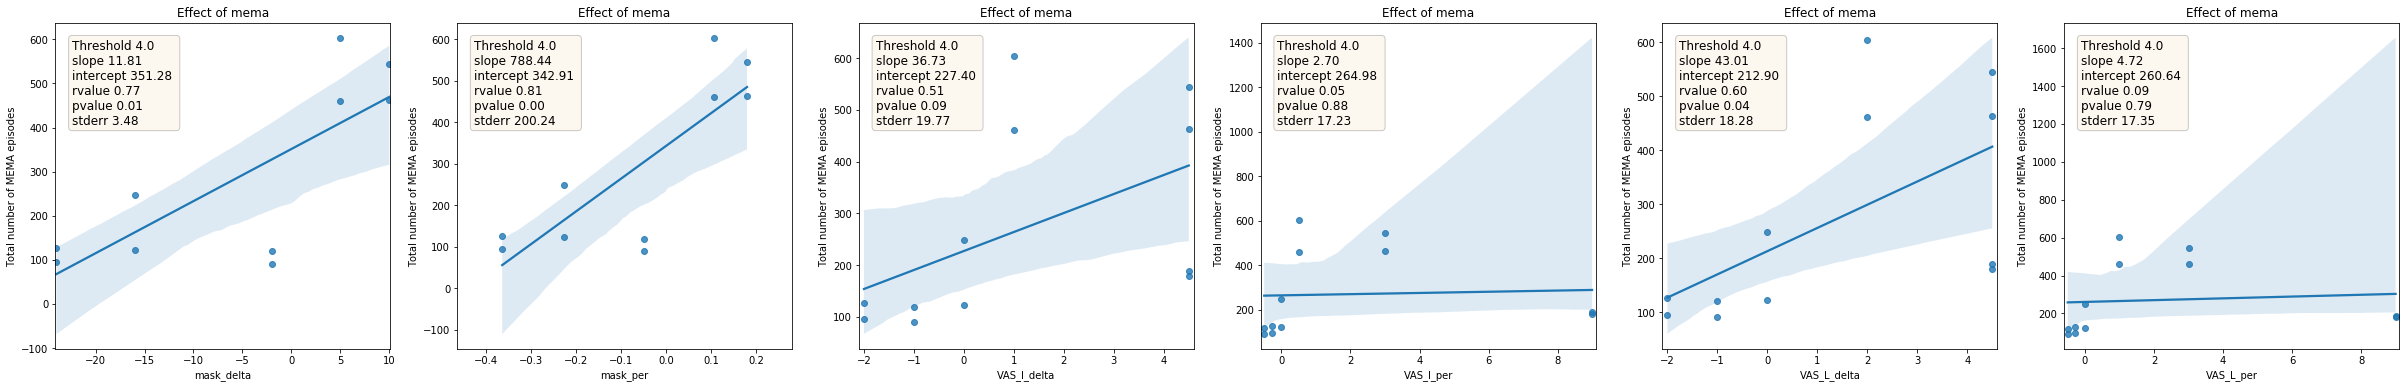

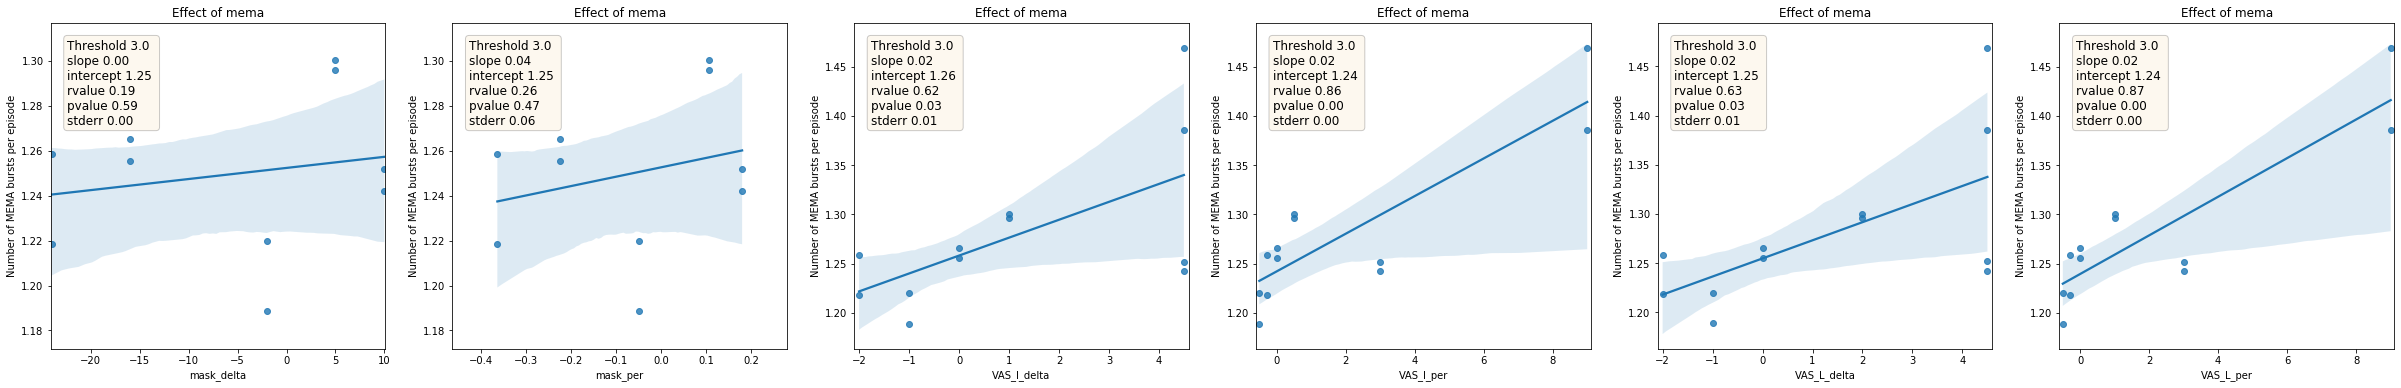

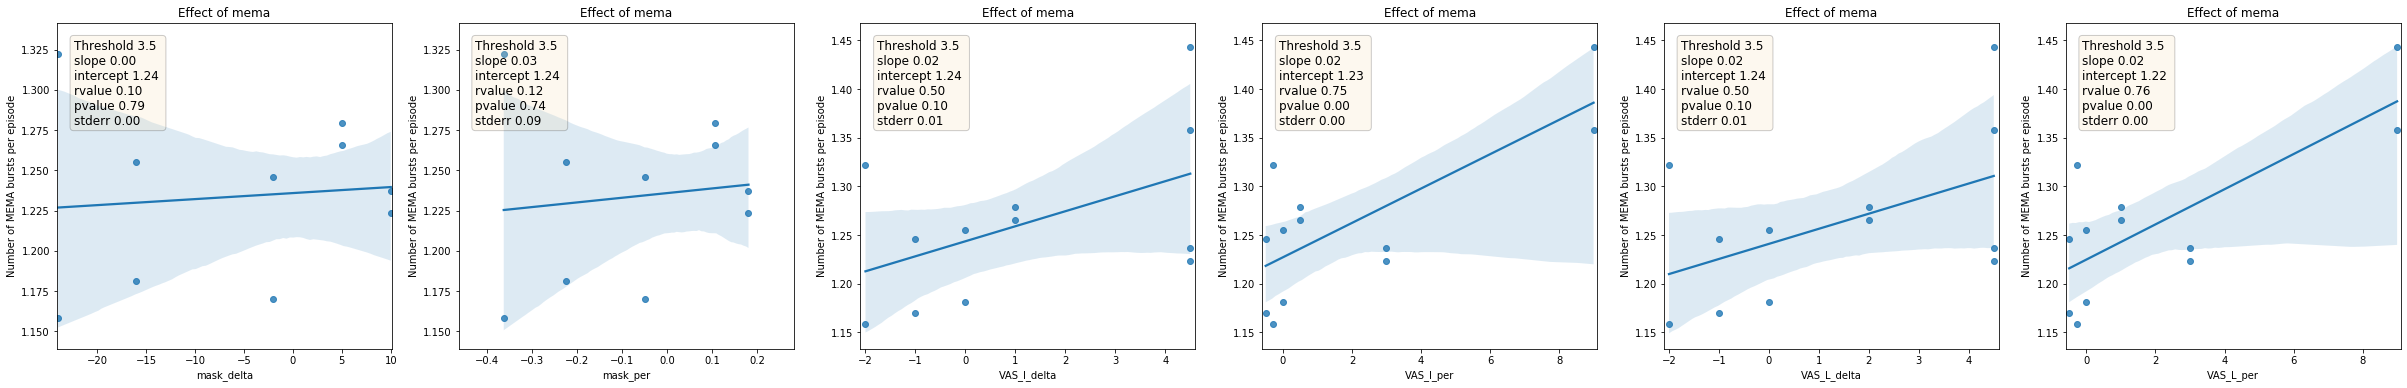

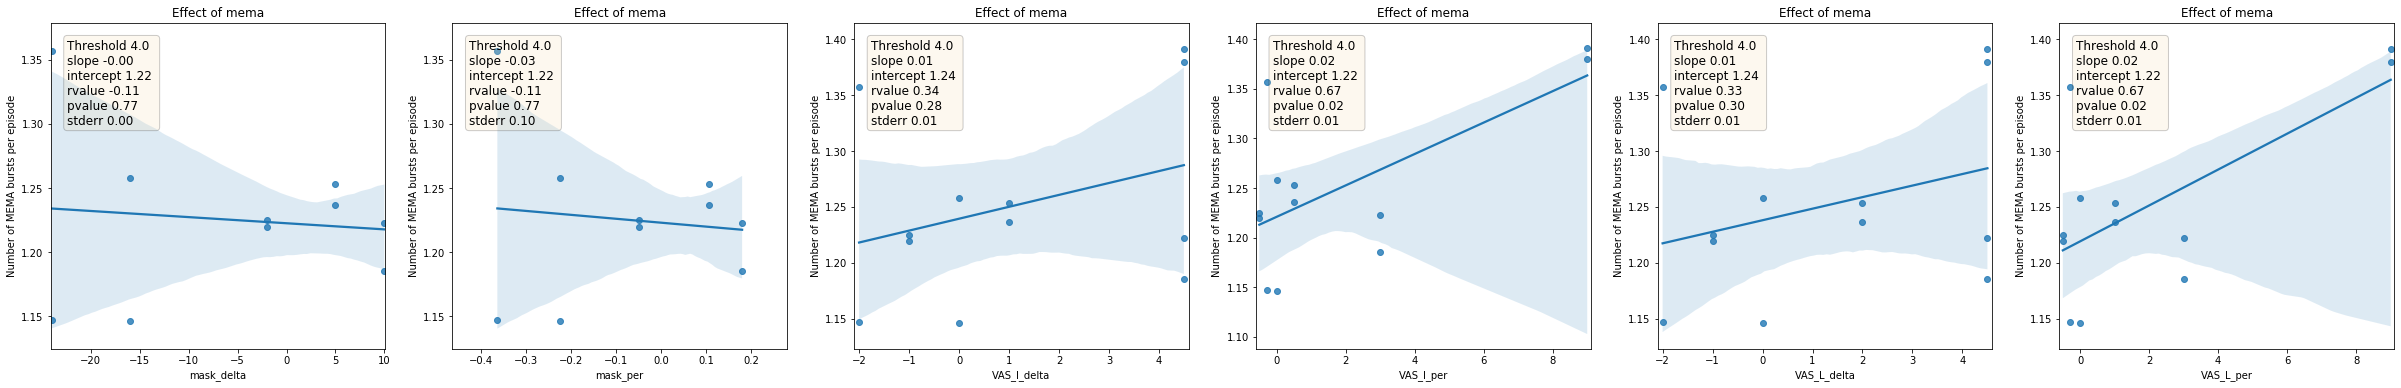

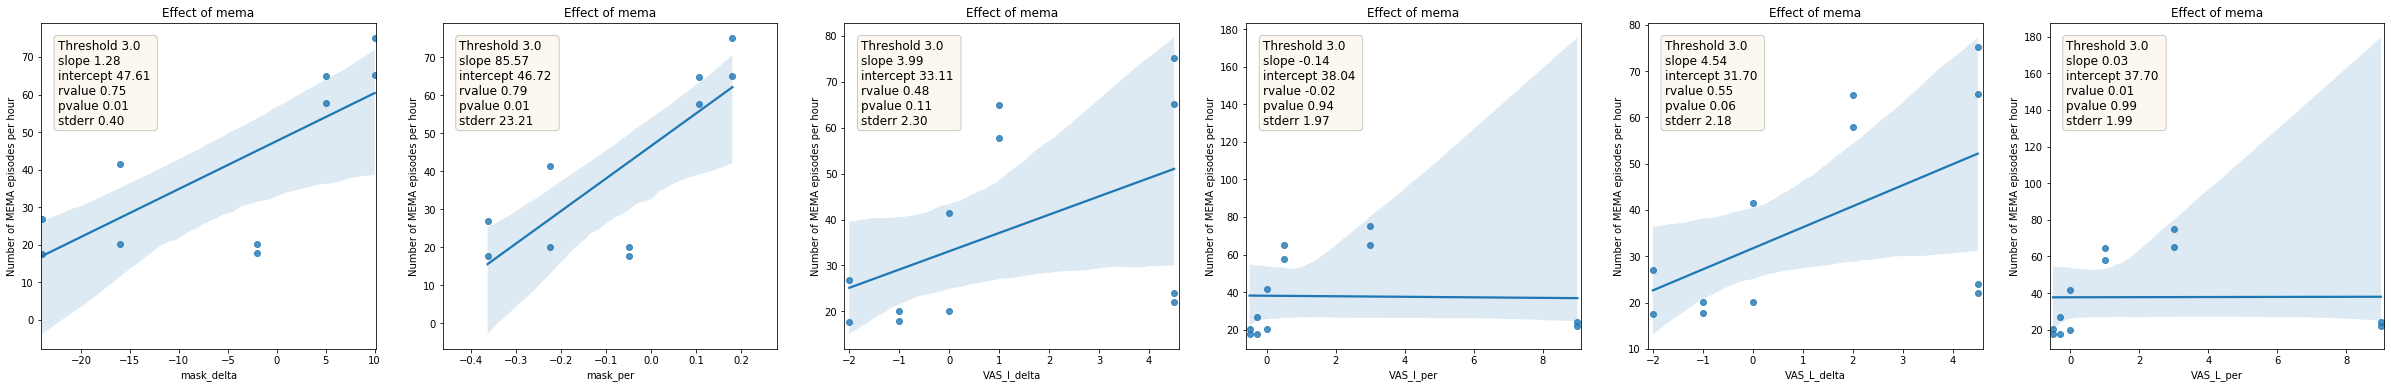

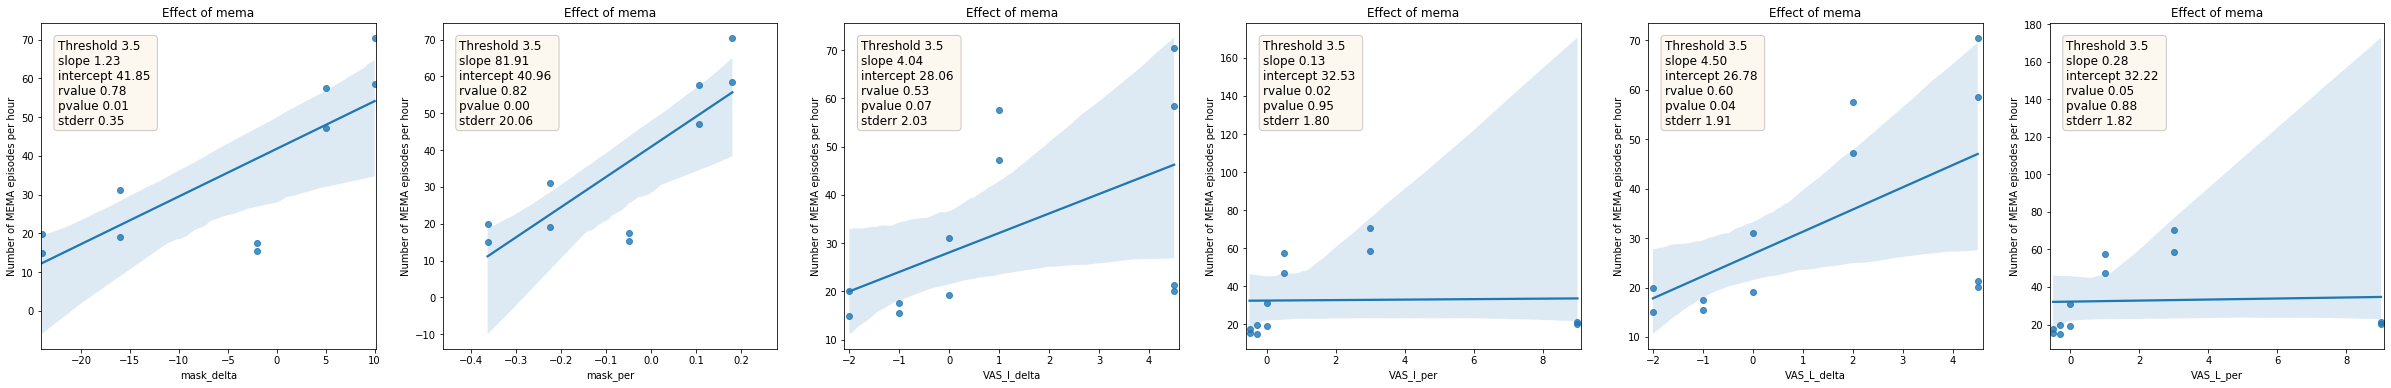

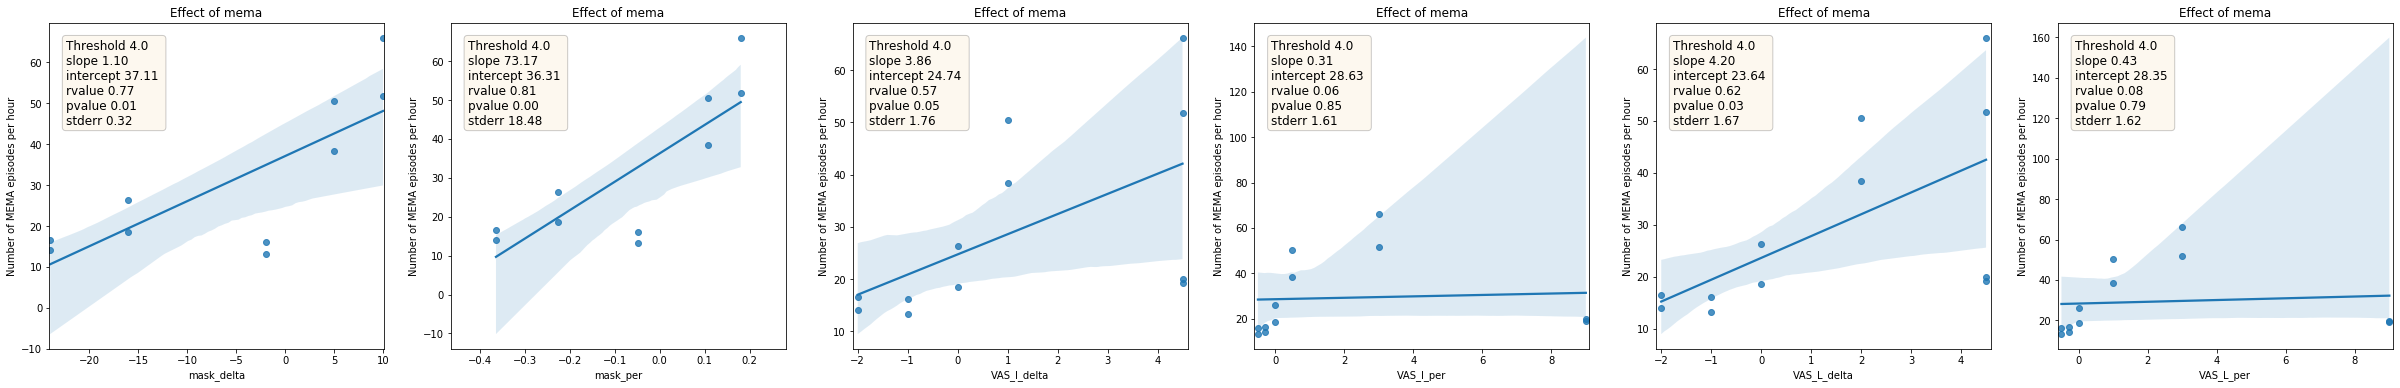

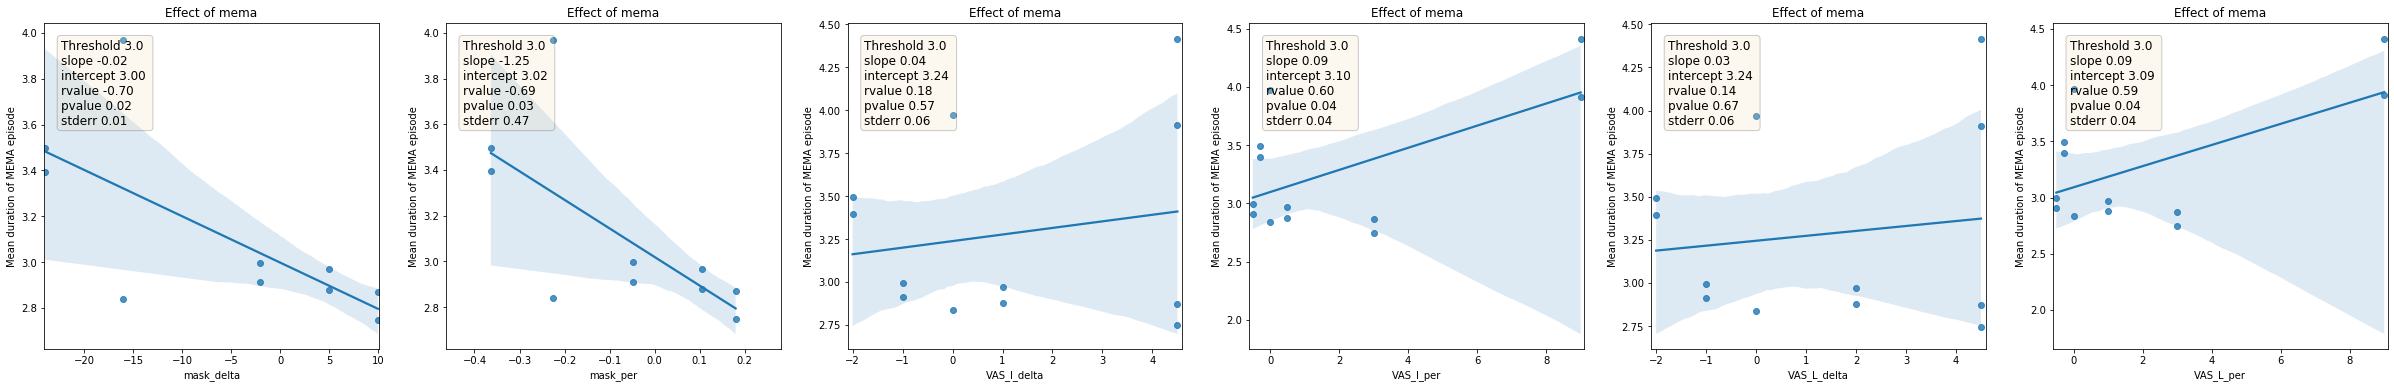

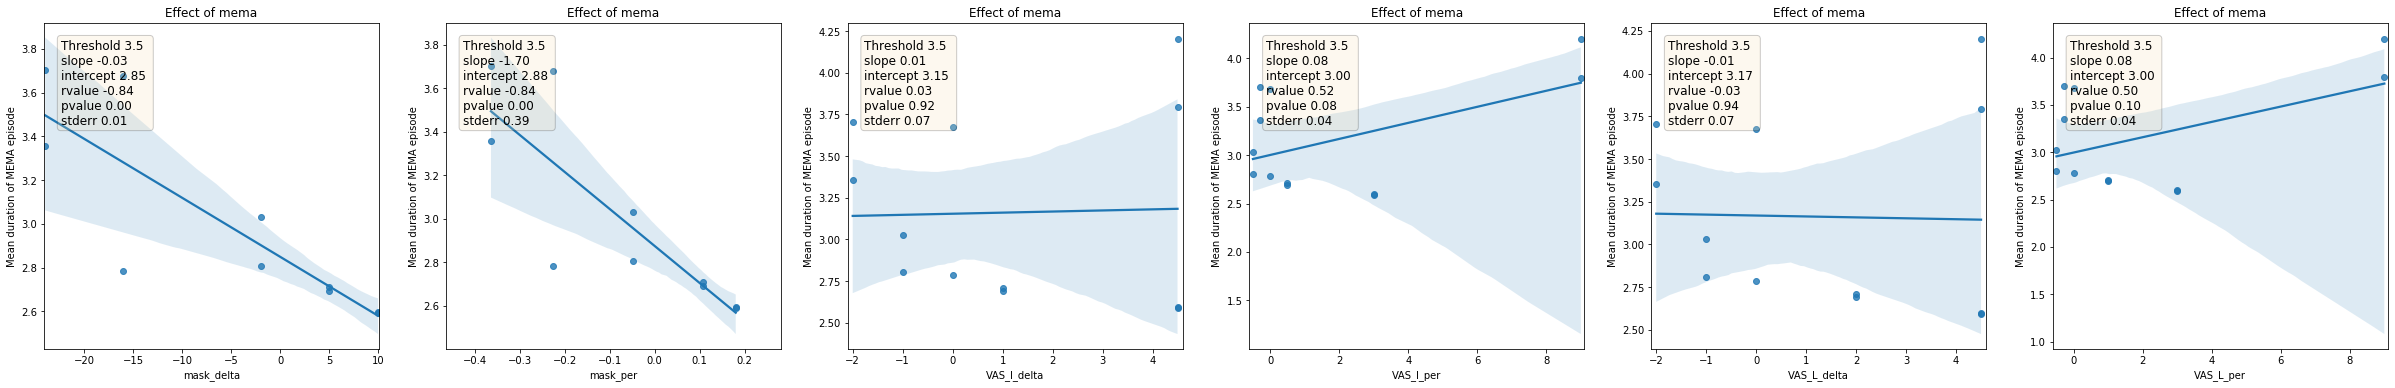

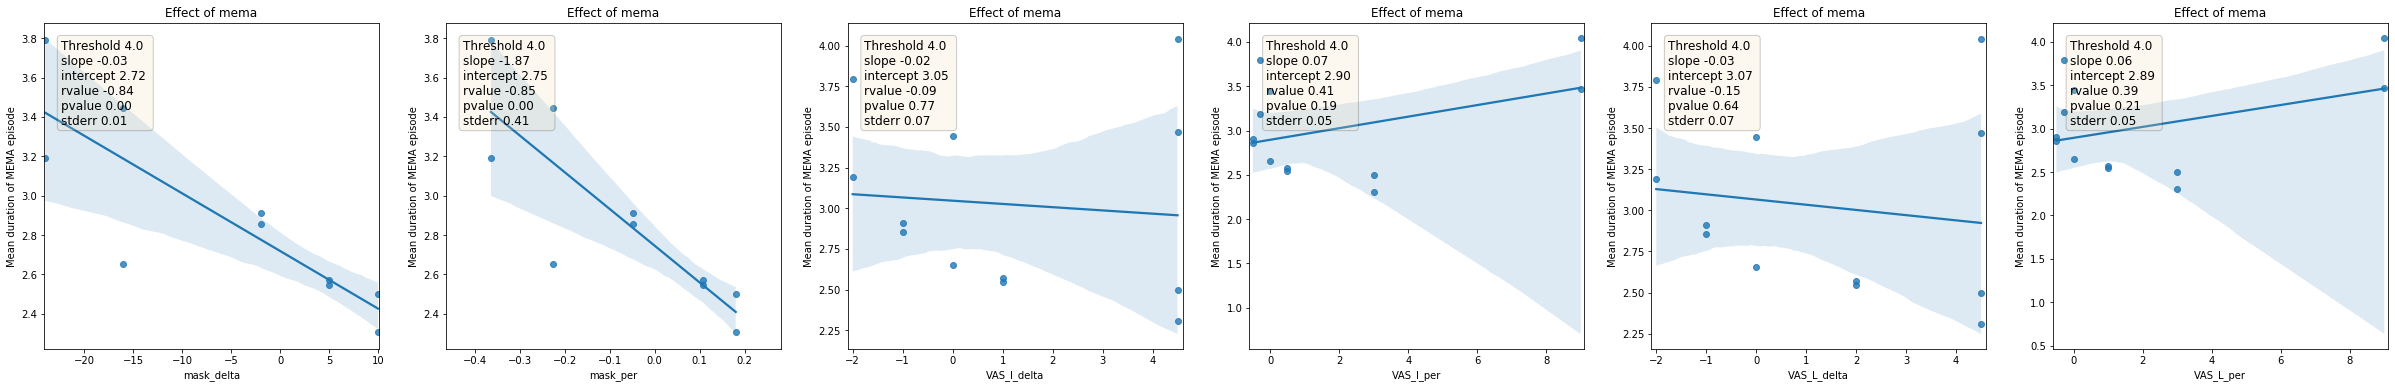

In [13]:
import seaborn as sns
plt.close("all")
meta_results = pd.DataFrame()

data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            df = pd.DataFrame({'x': data_loc[x_axis].values, 'y': data_loc[y_axis].values}).dropna()
            regression_result = scipy.stats.linregress(df.x,df.y)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of mema")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])



In [14]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,mask_delta,Total MEMA burst duration,3.0,30.813319,1136.468722,0.682390,0.029695,11.670000
0,mask_per,Total MEMA burst duration,3.0,2088.718299,1116.866068,0.732489,0.015984,686.340701
0,mask_delta,Total MEMA burst duration,3.5,25.554325,927.234154,0.707751,0.022028,9.018359
0,mask_per,Total MEMA burst duration,3.5,1725.688191,910.517329,0.756842,0.011268,526.892894
0,VAS_L_delta,Total MEMA burst duration,3.5,103.102009,627.615322,0.617998,0.032221,41.476462
0,mask_delta,Total MEMA burst duration,4.0,20.997642,773.028066,0.717322,0.019530,7.210803
0,mask_per,Total MEMA burst duration,4.0,1416.346208,759.177642,0.766196,0.009751,419.981656
0,VAS_L_delta,Total MEMA burst duration,4.0,88.119485,527.274687,0.653548,0.021174,32.271881
0,mask_delta,Total number of MEMA burst,3.0,18.089794,577.584887,0.709190,0.021639,6.358080
0,mask_per,Total number of MEMA burst,3.0,1217.652281,565.473189,0.755926,0.011425,372.832143


In [28]:
diff_nb_episodes = reports.loc[reports["condition"]=="habituation"]["Number of MEMA episodes per hour"].values - reports.loc[reports["condition"]=="resmed"]["Number of MEMA episodes per hour"].values
reports.loc[reports["condition"]=="habituation"]["THR_classif"].unique()

array([3. , 3.5, 4. ])

[ True False False  True False False  True False False  True False False
  True False False  True False False]
[False  True False False  True False False  True False False  True False
 False  True False False  True False]
[False False  True False False  True False False  True False False  True
 False False  True False False  True]


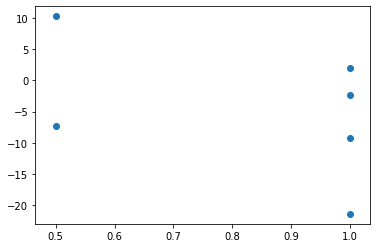

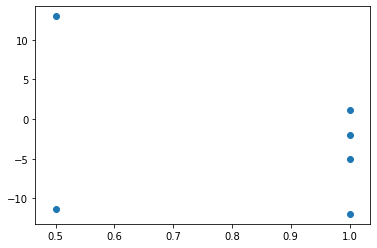

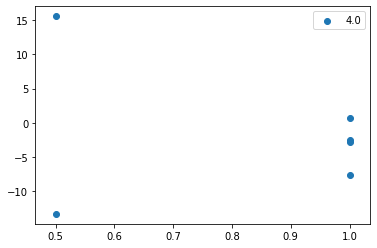

In [43]:
for threshold in reports["THR_classif"].unique():
    plt.figure()
    index = (reports.loc[reports["condition"]=="habituation"]["THR_classif"] == threshold).values
    print(index)
    plt.scatter(reports.loc[reports["condition"]=="habituation"]["Laterality"].values[index], diff_nb_episodes[index], label=threshold )
    
plt.legend()